In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats 
from scipy import stats
from sklearn import preprocessing
from  sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import scipy.sparse
from sklearn.feature_selection import RFE
from sklearn.linear_model import ElasticNet
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import xgboost 
from sklearn.grid_search import GridSearchCV
import re
from catboost import Pool, CatBoostClassifier
from sklearn.externals import joblib
import sklearn.metrics as metrics
from imblearn.combine import SMOTETomek
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


/home/ashwin/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'var']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [35]:
train=pd.read_csv('/home/ashwin/Downloads/hackerearth/sg/train.csv')
test=pd.read_csv('/home/ashwin/Downloads/hackerearth/sg/test.csv')

In [36]:
print(train.shape)
print(test.shape)

In [37]:
target=train['return']
train=train.drop('return',axis=1)
combain_data=train.append(test)
print(combain_data.shape)
print(combain_data.describe())

(14167, 17)
         start_date          sold  euribor_rate    libor_rate        bought  \
count  1.416700e+04  1.416500e+04  14167.000000  13428.000000  1.416500e+04   
mean   2.011755e+07  1.021504e+08      0.009157      0.975230  1.020694e+08   
std    3.033168e+04  1.755156e+08      0.013117      1.434853  1.754500e+08   
min    2.004041e+07  1.100000e+00     -0.003740     -0.667095  1.099698e+00   
25%    2.010031e+07  2.806100e+07      0.000970      0.241745  2.805996e+07   
50%    2.011121e+07  5.604500e+07      0.004280      0.531493  5.595940e+07   
75%    2.014080e+07  1.166000e+08      0.013510      1.084377  1.161812e+08   
max    2.017103e+07  1.320000e+10      0.050880      6.434407  1.320000e+10   

       creation_date     sell_date  
count   1.416700e+04  1.416700e+04  
mean    2.011754e+07  2.011818e+07  
std     3.032592e+04  3.042891e+04  
min     2.004072e+07  2.004071e+07  
25%     2.010031e+07  2.010033e+07  
50%     2.011121e+07  2.011122e+07  
75%     2.014080e

In [38]:
combain_data.isnull().sum()

portfolio_id         0
desk_id           5613
office_id            0
pf_category          0
start_date           0
sold                 2
country_code         0
euribor_rate         0
currency             0
libor_rate         739
bought               2
creation_date        0
indicator_code    8550
sell_date            0
type                 0
hedge_value       8552
status            4541
dtype: int64

In [39]:
combain_data=combain_data.drop('desk_id',axis=1)
combain_data=combain_data.drop('portfolio_id',axis=1)
combain_data['sold']=combain_data['sold'].fillna(combain_data['sold'].mean())
combain_data['bought']=combain_data['bought'].fillna(combain_data['bought'].mean())
combain_data['libor_rate']=combain_data['libor_rate']\
    .fillna(combain_data['libor_rate'].mean())
combain_data['indicator_code']=combain_data['indicator_code']\
    .fillna(False)
combain_data['hedge_value']=combain_data['hedge_value']\
    .fillna(True)
combain_data['status']=combain_data['hedge_value']\
    .fillna(False)

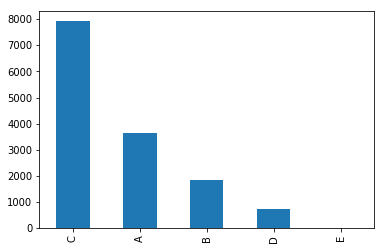

In [40]:
combain_data['pf_category'].value_counts().plot(kind='bar')

In [41]:

#combain_data=combain_data.dropna(thresh=0.8*(len(combain_data)),axis=1)
combain_data.shape


In [42]:
print(list(combain_data))

['office_id', 'pf_category', 'start_date', 'sold', 'country_code', 'euribor_rate', 'currency', 'libor_rate', 'bought', 'creation_date', 'indicator_code', 'sell_date', 'type', 'hedge_value', 'status']


In [43]:
combain_data['start_date']=combain_data['start_date'].astype('str')
combain_data['creation_date']=combain_data['creation_date'].astype('str')
combain_data['sell_date']=combain_data['sell_date'].astype('str')

combain_data['start_date']=combain_data['start_date']\
    .apply(lambda x:x[0:4]+'-'+x[4:6]+'-'+x[6:])
combain_data['creation_date']=combain_data['creation_date']\
    .apply(lambda x:x[0:4]+'-'+x[4:6]+'-'+x[6:])
combain_data['sell_date']=combain_data['sell_date']\
    .apply(lambda x:x[0:4]+'-'+x[4:6]+'-'+x[6:])

combain_data['start_date']=pd.to_datetime(combain_data['start_date'])
combain_data['creation_date']=pd.to_datetime(combain_data['creation_date'])
combain_data['sell_date']=pd.to_datetime(combain_data['sell_date'])

combain_data['start_sell']=(combain_data['sell_date']
                              -combain_data['start_date'])/np.timedelta64(1, 'D')
combain_data['creation_sell']=(combain_data['sell_date']
                              -combain_data['creation_date'])/np.timedelta64(1, 'D')
combain_data['start_creation']=(combain_data['start_date']
                              -combain_data['creation_date'])/np.timedelta64(1, 'D')

combain_data['year_sd'] = combain_data['start_date'].dt.year
combain_data['month_sd'] = combain_data['start_date'].dt.month
combain_data['day_sd'] = combain_data['start_date'].dt.day

combain_data['year_cd'] = combain_data['creation_date'].dt.year
combain_data['month_cd'] = combain_data['creation_date'].dt.month
combain_data['day_cd'] = combain_data['creation_date'].dt.day

combain_data['year_ssd'] = combain_data['sell_date'].dt.year
combain_data['month_ssd'] = combain_data['sell_date'].dt.month
combain_data['day_ssd'] = combain_data['sell_date'].dt.day

In [44]:
combain_data=combain_data.drop('start_date',axis=1)
combain_data=combain_data.drop('creation_date',axis=1)
combain_data=combain_data.drop('sell_date',axis=1)

In [45]:
combain_data[['indicator_code','hedge_value','status']]=\
    combain_data[['indicator_code','hedge_value','status']].astype('str')


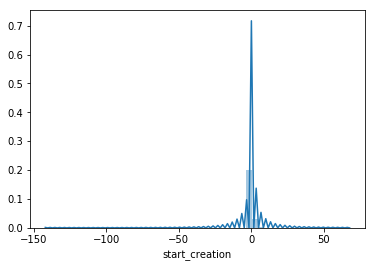

In [46]:

sns.distplot(combain_data['start_creation'])

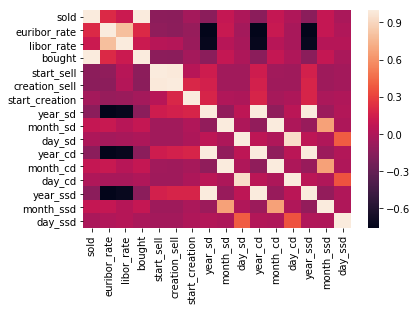

In [47]:
#print(stats.stats.pearsonr(combain_data,combain_data))
#np.corrcoef(combain_data,combain_data)
#plt.matshow(combain_data.corr())
corr = combain_data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [48]:
combain_data=combain_data.drop('sold',axis=1)
combain_data=combain_data.drop('creation_sell',axis=1)
combain_data=combain_data.drop('year_cd',axis=1)
combain_data=combain_data.drop('month_cd',axis=1)
combain_data=combain_data.drop('day_cd',axis=1)
combain_data=combain_data.drop('year_ssd',axis=1)
#sns.regplot(x=combain_data['euribor_rate'], y=combain_data['year_sd'], data=combain_data)
#sns.regplot(x=combain_data['libor_rate'], y=combain_data['year'], data=combain_data)

In [49]:
combain_data[['year_sd', 'month_sd', 'day_sd', 'month_ssd', 'day_ssd']]=\
combain_data[['year_sd', 'month_sd', 'day_sd', 'month_ssd','day_ssd']].astype('str')

In [50]:
#combain_data['euribor_libour']=combain_data['euribor_rate']*combain_data['libor_rate']
#combain_data['euribor_bought']=combain_data['euribor_rate']*combain_data['bought']
#combain_data['euribor_start_sell']=combain_data['euribor_rate']*combain_data['start_sell']
#combain_data['euribor_start_creation']=combain_data['euribor_rate']*combain_data['start_creation']
#combain_data['libour_bought']=combain_data['libor_rate']*combain_data['bought']
#combain_data['libour_start_sell']=combain_data['libor_rate']*combain_data['start_sell']
#combain_data['euribor_start_creation']=combain_data['libor_rate']*combain_data['start_creation']
#combain_data['bought_start_sell']=combain_data['bought']*combain_data['start_sell']
#combain_data['bought_start_creation']=combain_data['bought']*combain_data['start_creation']
#combain_data['start_sell_start_creation']=combain_data['start_sell']*combain_data['start_creation']

In [51]:
combain_data.dtypes

office_id          object
pf_category        object
country_code       object
euribor_rate      float64
currency           object
libor_rate        float64
bought            float64
indicator_code     object
type               object
hedge_value        object
status             object
start_sell        float64
start_creation    float64
year_sd            object
month_sd           object
day_sd             object
month_ssd          object
day_ssd            object
dtype: object

In [53]:
#combain_data['country_currency'] = \
#    combain_data[['country_code', 'currency']].apply(lambda x: ''.join(x), axis=1)
#combain_data['month_sd_ssd'] = \
#    combain_data[['month_sd', 'month_ssd']].apply(lambda x: ''.join(x), axis=1)
#combain_data['day_sd_ssd'] = \
#    combain_data[['day_sd', 'day_ssd']].apply(lambda x: ''.join(x), axis=1)
#combain_data['indicator_code_type'] = \
#    combain_data[['indicator_code', 'type']].apply(lambda x: ''.join(x), axis=1)
#combain_data['hedge_value_status'] = \
#    combain_data[['hedge_value', 'status']].apply(lambda x: ''.join(x), axis=1)
#combain_data['country_currency_indicator'] = \
#    combain_data[['country_code', 'currency','indicator_code']].apply(lambda x: ''.join(x), axis=1)
#combain_data['hedge_value_status_type'] =\
#    combain_data[['hedge_value', 'status','type']].apply(lambda x: ''.join(x), axis=1)

In [54]:
combain_data[['indicator_code','hedge_value','status']]=\
    combain_data[['indicator_code','hedge_value','status']].astype('object')


In [55]:

numerical_var=[f for f in combain_data.columns if combain_data.dtypes[f] 
        == 'float64']
catagorical_var=[f for f in combain_data.columns if combain_data.dtypes[f] 
                 == 'object']
#catagorical_var.extend(['year_sd', 'month_sd', 'day_sd', 'month_ssd',
#              'day_ssd'])

catagorical_var

['office_id',
 'pf_category',
 'country_code',
 'currency',
 'indicator_code',
 'type',
 'hedge_value',
 'status',
 'year_sd',
 'month_sd',
 'day_sd',
 'month_ssd',
 'day_ssd']

In [56]:
numerical_var

['euribor_rate', 'libor_rate', 'bought', 'start_sell', 'start_creation']

In [57]:
dummy_data=pd.get_dummies(combain_data[catagorical_var])
dummy_data.shape

(14167, 131)

In [58]:
for var in numerical_var:
        print(var)
        print(stats.skew(combain_data[var]))

euribor_rate
1.666003850796887
libor_rate
1.7699014547206413
bought
31.32457648642434
start_sell
1.3599215619073817
start_creation
-13.209380668777703


In [59]:
scaler = preprocessing.StandardScaler()
i=0
combain_data1=pd.DataFrame()
while(i<=5):
    for c in numerical_var:
        #if c not in ['start_sell','creation_sell']:
        if c not in ['start_sell','creation_sell','euribor_bought','euribor_start_sell','libour_bought','libour_start_sell','bought_start_sell' ]:
            if(stats.skew(combain_data[c])>0 and stats.skew(combain_data[c])>0.75):
                combain_data1[c]=np.log1p(combain_data[c])
            elif(stats.skew(combain_data[c])<0 and stats.skew(combain_data[c])<-0.75):
                combain_data1[c] = combain_data[c]**3
                combain_data1[c] = scaler.fit_transform(combain_data[[c]])
        elif c not in ['euribor_bought','euribor_start_sell']:
            combain_data1[c] = scaler.fit_transform(combain_data[[c]])
        else:
            combain_data1[c]=combain_data[c]
    i=i+1

In [60]:
for var in numerical_var:
        print(var)
        print(stats.skew(combain_data1[var]))

euribor_rate
1.641394536110161
libor_rate
-0.15310359978936172
bought
-1.723767528254821
start_sell
1.3599215619073817
start_creation
-13.209380668777692


In [61]:

combain_data=combain_data1
combain_data=pd.concat([combain_data,dummy_data],axis=1)
combain_data.shape

(14167, 136)

In [62]:
train=combain_data[:9366]
test=combain_data[9366:]

In [63]:
test_data=pd.read_csv('/home/ashwin/Downloads/hackerearth/sg/test.csv')
lasso_mod=Lasso(normalize=True)
parameters = {'alpha':[0.0001,0.001,0.01,0.1,1,5,10,20]}
lasso_reg = GridSearchCV(lasso_mod, parameters, n_jobs=-1,  
                   scoring='r2',cv=10,
                 refit=True)
lasso_reg.fit(train,target)

predictions=lasso_reg.predict(test)
submission=pd.DataFrame()
submission['portfolio_id']=test_data['portfolio_id']
submission['return']=predictions
submission.to_csv('/home/ashwin/Downloads/hackerearth/sg/submissionlasso.csv'
                  ,index=False)

In [31]:
test_data=pd.read_csv('/home/ashwin/Downloads/hackerearth/sg/test.csv')
regr = LinearRegression( normalize=True)
regr.fit(train,target)
predictions=regr.predict(test)
submission=pd.DataFrame()
submission['portfolio_id']=test_data['portfolio_id']
submission['return']=predictions
submission.to_csv('/home/ashwin/Downloads/hackerearth/sg/submissionleniar.csv'
                  ,index=False)

In [33]:
test_data=pd.read_csv('/home/ashwin/Downloads/hackerearth/sg/test.csv')
ridge_mod=Ridge(normalize=True,max_iter=100000)
parameters = {'alpha':[0.0001,0.001,0.01,0.1,1,5,10,20,50,100,1000,2500]}
ridge_reg = GridSearchCV(ridge_mod, parameters, n_jobs=-1,  
                   scoring='r2',cv=50,
                 refit=True)
ridge_reg.fit(train,target)

predictions=ridge_reg.predict(test)
submission=pd.DataFrame()
submission['portfolio_id']=test_data['portfolio_id']
submission['return']=predictions
submission.to_csv('/home/ashwin/Downloads/hackerearth/sg/submissionridge.csv'
                  ,index=False)

In [ ]:
test_data=pd.read_csv('/home/ashwin/Downloads/hackerearth/sg/test.csv')
model = RandomForestRegressor(n_estimators = 2000, oob_score = True, 
                n_jobs = -1)
model.fit(train,target)
#rfe = RFE(model, 50)
#model_ref = rfe.fit(train, target)
predictions=model.predict(test)
submission=pd.DataFrame()
submission['portfolio_id']=test_data['portfolio_id']
submission['return']=predictions
submission.to_csv('/home/ashwin/Downloads/hackerearth/sg/submissionrf.csv'
                  ,index=False)

In [1]:
,max_features = "auto"
                                   , min_samples_leaf = 1

In [ ]:
test_data=pd.read_csv('/home/ashwin/Downloads/hackerearth/sg/test.csv')
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.01, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=15)
xgb.fit(scipy.sparse.csr_matrix(train),target)
predictions=xgb.predict(scipy.sparse.csr_matrix(test))
submission=pd.DataFrame()
submission['portfolio_id']=test_data['portfolio_id']
submission['return']=predictions
submission.to_csv('/home/ashwin/Downloads/hackerearth/sg/submissionxgb.csv'
                  ,index=False)
